In [39]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from iapws import IAPWS97 as w_props
import hjson
# from utils import filter_nan, get_Q_from_3wv_model
from loguru import logger

# auto reload modules
%load_ext autoreload

# Parameters
sample_rate = '60s'

# Paths definition
# src_path = Path(f'{os.getenv("HOME")}/Nextcloud/Juanmi_MED_PSA/EURECAT/')
base_path = Path( f'{os.getenv("HOME")}/development_psa/models_psa')
data_path = base_path / 'data/calibration/20230707_20230710_datos_tanques.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Matplotlib visualizations settings
import seaborn as sns
import matplotlib.dates as mdates

sns.set_theme()
myFmt = mdates.DateFormatter('%H:%M')
plot_colors = sns.color_palette()

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
formatter.formats = ['%y',  # ticks are mostly years
                     '%b',       # ticks are mostly months
                     '%d',       # ticks are mostly days
                     '%H:%M',    # hrs
                     '%H:%M',    # min
                     '%S.%f', ]  # secs
# these are mostly just the level above...
formatter.zero_formats = [''] + formatter.formats[:-1]
# ...except for ticks that are mostly hours, then it is nice to have
# month-day:
formatter.zero_formats[3] = '%d-%b'

formatter.offset_formats = ['',
                            '%Y',
                            '%b %Y',
                            '%d %b %Y',
                            '%d %b %Y',
                            '%d %b %Y %H:%M', ]

In [41]:
# Load data

# Load variables information
with open( base_path / 'data/variables_config.hjson') as f:
    vars_config = hjson.load(f)

# Read data from csv, the index column is the one named "time", which is not the first one
df = pd.read_csv(data_path, parse_dates=True, index_col='TimeStamp')

# Rename index column to "time"
df.index.names = ['time']

# Set UTC timezone
df = df.tz_localize('UTC')

display(df.head())

,TT-SF-004,TT-SF-005,TT-SF-006,TT-SF-001,TT-SF-002,TT-SF-003,TT-DES-030,FT-SF-001,FT-AQU-100,TT-SF-008,TT-AQU-109,FT-AQU-101,TT-AQU-106,TT-SF-007,ZT-AQU-TCV102
time,,,,,,,,,,,,,,,
2023-07-07 08:00:00+00:00,83.9555,83.6752,75.9921,83.4058,83.4982,54.4213,25.8363,0.0,0.008681,43.6488,54.8220,0.009476,72.3661,41.9049,0.542534
2023-07-07 08:00:01+00:00,83.9589,83.6786,75.9921,83.4025,83.5015,54.4213,25.8512,0.0,0.008681,43.6694,54.8186,0.009109,72.3729,41.9049,0.542534
2023-07-07 08:00:02+00:00,83.9589,83.6752,75.9954,83.4058,83.5015,54.4213,25.8413,0.0,0.008681,43.6866,54.8018,0.009476,72.3997,41.9150,0.611259
2023-07-07 08:00:03+00:00,83.9622,83.6752,75.9921,83.4058,83.5015,54.4213,25.8264,0.0,0.008681,43.6900,54.7880,0.010208,72.4236,41.9217,0.542534
2023-07-07 08:00:04+00:00,83.9589,83.6719,75.9954,83.4092,83.4982,54.4213,25.8512,0.0,0.008681,43.7000,54.7880,0.009109,72.3896,41.9217,0.542534


In [42]:
# Preprocessing
from phd_visualizations.utils import rename_signal_ids_to_var_ids
from phd_visualizations.utils.units import unit_conversion

%autoreload 2

# Sample every `sample_rate` seconds to reduce the size of the dataframe
df = df.resample(sample_rate).mean()

# Rename columns from signal_id to var_id
df = rename_signal_ids_to_var_ids(df, vars_config)

# Flow meter of Qdis is broken, using the output of the three-way valve 
# model as an alternative
# data_Qdis = get_Q_from_3wv_model(datos_date_str, sample_rate_str=sample_rate_str)

# df["Tts_b_in"] = df["Tts_b_in"].values() if 'Tts_b_in' in df.columns else np.zeros(len(data))

# Merge both dataframes so they are synced in time
# data.rename(columns={'m_ts_dis': 'm_ts_dis_sensor'}, inplace=True) # Rename the invalid signal
# data = pd.merge(data, data_Qdis, left_index=True, right_index=True, how='outer')

# Convert units
df = unit_conversion(df, vars_config, input_unit_key='units_scada', output_unit_key='units_model')

display(df.head())

2024-02-04 14:36:55.340 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:35 - Signal id RE-SF-001 not found in dataframe columns.
2024-02-04 14:36:55.341 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:35 - Signal id TE-DES-015 not found in dataframe columns.
2024-02-04 14:36:55.341 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:35 - Signal id CT-DES-001 not found in dataframe columns.
2024-02-04 14:36:55.342 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:35 - Signal id TT-AQU-107a not found in dataframe columns.
2024-02-04 14:36:55.342 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:35 - Signal id HW1TT21 not found in dataframe columns.
2024-02-04 14:36:55.343 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:35 - Signal id SW2TC1 not found in dataframe columns.
2024-02-04 14:36:55.343 | WARNING  | phd_visualizations.utils:rename_signal_ids_to_var_ids:35 - Signal id FT-DES-

,Tts_h_t,Tts_h_m,Tts_h_b,Tts_c_t,Tts_c_m,Tts_c_b,Tamb,qts_src,qmed_s,Tts_h_t_in,...,Tts_src_in,Tts_dis,Tts_dis_in,Thx_s_in,Thx_s_out,qhx_s,T3wv_src,T3wv_dis_out,q3wv_src,q3wv_dis
time,,,,,,,,,,,,,,,,,,,,,
2023-07-07 08:00:00+00:00,83.957478,83.675723,75.990212,83.402810,83.498845,54.420238,25.827827,0.0,0.03125,43.863983,...,43.863983,72.440378,42.067722,42.067722,43.863983,0.0,83.957478,54.773447,0.033151,0.03125
2023-07-07 08:01:00+00:00,83.955357,83.674718,75.987573,83.402808,83.497790,54.417053,25.836833,0.0,0.03125,44.193478,...,44.193478,72.388942,42.402228,42.402228,44.193478,0.0,83.955357,54.776762,0.032750,0.03125
2023-07-07 08:02:00+00:00,83.954737,83.672322,75.986180,83.398007,83.495307,54.382018,25.899068,0.0,0.03125,44.445102,...,44.445102,72.474715,42.736758,42.736758,44.445102,0.0,83.954737,54.725432,0.033109,0.03125
2023-07-07 08:03:00+00:00,83.952403,83.669303,75.968895,83.394710,83.491415,54.362908,25.992837,0.0,0.03125,44.673815,...,44.673815,72.365853,43.077862,43.077862,44.673815,0.0,83.952403,54.716210,0.033136,0.03125
2023-07-07 08:04:00+00:00,83.951673,83.669247,75.955570,83.392928,83.486873,54.357070,26.060533,0.0,0.03125,45.004507,...,45.004507,72.414092,43.423360,43.423360,45.004507,0.0,83.951673,54.670815,0.033043,0.03125


In [43]:
logger.debug(list(df.columns))

2024-02-04 14:36:55.412 | DEBUG    | __main__:<module>:1 - ['Tts_h_t', 'Tts_h_m', 'Tts_h_b', 'Tts_c_t', 'Tts_c_m', 'Tts_c_b', 'Tamb', 'qts_src', 'qmed_s', 'Tts_h_t_in', 'Tts_c_b_in', 'qts_dis', 'Tts_h_out', 'Tts_c_b_out', 'ZT-AQU-TCV102', 'Tts_src_in', 'Tts_dis', 'Tts_dis_in', 'Thx_s_in', 'Thx_s_out', 'qhx_s', 'T3wv_src', 'T3wv_dis_out', 'q3wv_src', 'q3wv_dis']


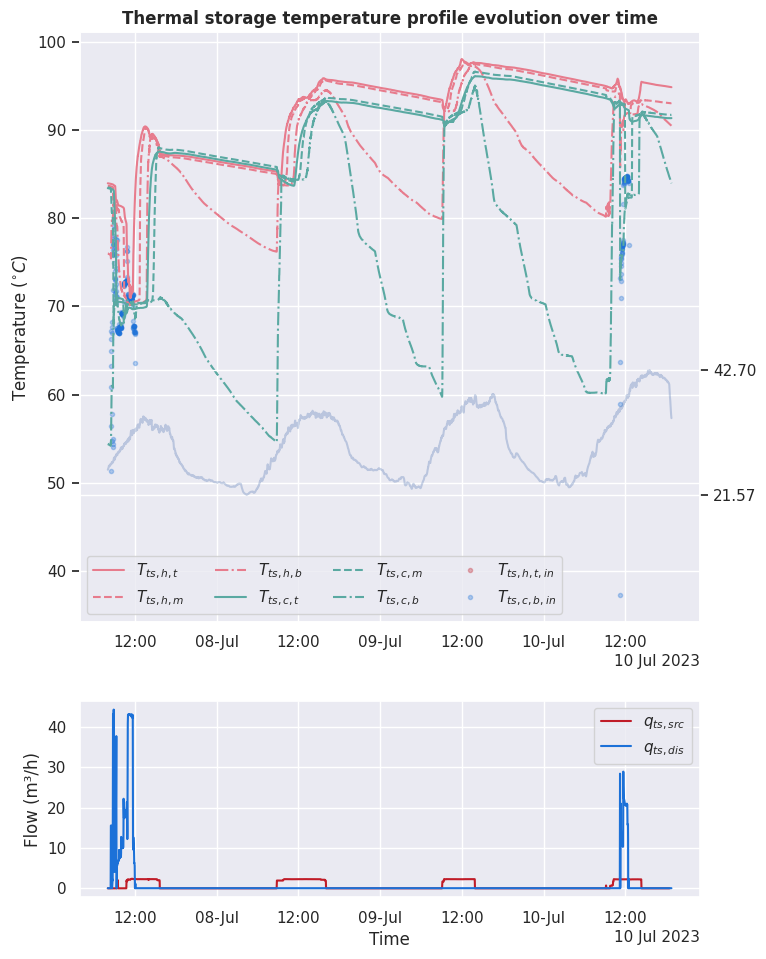

In [50]:
# Visualize data
# TODO: Temporal, once protoyped move to phd_visualizations

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from phd_visualizations.constants import color_palette

idxs_src = (df["qts_src"] > 5).values
idxs_dis = (df["qts_dis"] > 0.1).values if "qts_dis" in df.columns else None

color_src = "#c01c28"
color_dis = "#1c71d8"

colors = [color_palette['cool_red'], color_palette['cool_green']]

# Create a figure and axis
# fig, ax = plt.subplots()
fig = plt.figure(figsize=(8,10),) #constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax = fig.add_subplot(gs[0])

# Plot each temperature signal
for var_name in ['Tts_h_t', 'Tts_h_m', 'Tts_h_b', 'Tts_c_t', 'Tts_c_m', 'Tts_c_b',]:
    if var_name not in ["time", "Tts_h_t_in", "Tts_c_b_in"] and var_name.startswith('Tts'):
        if var_name.startswith('Tts_h'):
            color = colors[0]
        else:
            color = colors[1]
            
        if var_name.endswith('t'):
            line_type = 'solid'
        elif var_name.endswith('m'):
            line_type = 'dashed'
        else:
            line_type = 'dashdot'
            
        var_label = vars_config[var_name]['label_latex']
        
        ax.plot(df.index, df[var_name], linestyle=line_type, label=var_label, color=color)
    
# Source temperature
ax.plot(df.iloc[idxs_src].index, df.iloc[idxs_src]["Tts_h_t_in"], '.',color=color_src, alpha=0.3, label=vars_config['Tts_h_t_in']['label_latex'], zorder=1)
# Discharge temperature
ax.plot(df.index[idxs_dis], df["Tts_c_b_in"][idxs_dis], '.',color=color_dis, alpha=0.3, label=vars_config['Tts_c_b_in']['label_latex'], zorder=1)

ax.set_xticks([]); ax.set_xticklabels([])

# Ambient temperature
ax_r = ax.twinx()
ax_r.set_axisbelow(True)
ax_r.plot(df.index, df['Tamb'], label='$T_{amb}$ (right)', alpha=0.3)
ax_r.set_ylim([0, 100])
ax_r.set_yticks([df['Tamb'].min(), df['Tamb'].max()])
# ax_r.tick_params(axis='both', which='both', zorder=-10)

# Remove x-axis labels
ax.set_xticklabels([])
ax_r.set_xticklabels([])

# Set labels and title
ax.set_ylabel('Temperature ($^{\circ}C$)')
ax.set_title('Thermal storage temperature profile evolution over time', fontweight='bold')

# Add legend
ax.legend(ncols=4)
# ax.tick_params(axis='x', which='both',
#                 bottom=False) # turn off major & minor ticks on the bottom
# x0 = round(193_000/ts)
# duration = round(20*3600/ts)
# xrange=[x0, round(x0+duration)]
# ax.axvspan(df.index[xrange[0]], df.index[xrange[1]], alpha=0.3)
# Remove x-axis label


# Flows plot
ax = fig.add_subplot(gs[1], sharex=ax)

ax.plot(df.index, df["qts_src"], color=color_src, label=vars_config["qts_src"]["label_latex"])
# ax.legend()
# ax.set_ylabel(f'{var_labels["qts_src"]} (L/min)')

# ax = ax.twinx()
# ax.set_axisbelow(True)
ax.plot(df.index, df["qts_dis"], color=color_dis, label=vars_config["qts_dis"]["label_latex"])
ax.legend()
ax.set_ylabel('Flow (m³/h)')


ax.set_xlabel('Time')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# fig.set_constrained_layout_pads(hspace=0.0, h_pad=0.0)  
# Adjust the spacing between subplots
plt.subplots_adjust(top=0.940, bottom=0.075)

# Display the plot
plt.show()

## Test model prior to parameter fit

In [ ]:
from models_psa import thermal_storage_model_two_tanks, thermal_storage_model_single_tank
from parameters_fit import calculate_iae, calculate_ise, calculate_itae
from visualization.calibrations import plot_model_result_thermal_storage


# Parameters
Tmin = 60 # Minimum useful temperature, °C
N = 3 # Number of volumes
V = 15 # Volume of an individual tank, m³
Vt = 15*2 # Total volume of the storage system (V tank·N tanks)
Tmin = 60 # Minimum useful temperature, °C
V_i = np.ones(N)*V/N  # Volume of each control volume

# Model parameters
UA_h  = np.array([0.0068, 0.004, 0.0287])
# Vi_h = np.array([2.9722, 1.7128, 9.4346])
Vi_h  = V_i.copy()

UA_c  = np.array([0.0068, 0.004, 0.0287])
# Vi_c = np.array([2.9722, 1.7128, 9.4346])
Vi_c = V_i.copy()

# Inputs 

# Since we are using the first output as starting point, start from the second value
Ti_ant_h = np.array( [data[T][0] for T in Tin_labels_h] )
Ti_ant_c = np.array( [data[T][0] for T in Tin_labels_c] )
Tt_in = data.Tts_t_in.values[1:]
Tb_in = data.Tts_b_in.values[1:] if 'Tts_b_in' in data.columns else np.zeros(len(data)-1)

Tamb = data.Tamb.values[1:]
Qsrc = data.mts_src.values[1:] if 'mts_src' in data.columns else np.zeros(len(data)-1)
Qdis = data.mts_dis.values[1:] if 'mts_dis' in data.columns else np.zeros(len(data)-1)


msrc = np.zeros(len(data)-1, dtype=float); mdis = np.zeros(len(data)-1, dtype=float)
for idx in range(1, len(data)-1):
    msrc[idx] = Qsrc[idx]/60*w_props(P=0.1, T=Tt_in[idx]+273.15).rho*1e-3 # rho [kg/m³] # Convertir L/min a kg/s
    mdis[idx] = Qdis[idx]*w_props(P=0.1, T=data.Tts_h_t[idx]+273.15).rho*1e-3 # rho [kg/m³] # Convertir L/s a kg/s

# Experimental outputs
Ti_ref = np.concatenate((data[Tin_labels_h].values[1:], data[Tin_labels_c].values[1:]), axis=1)

# Initialize result vectors
Ti_h_mod   = np.zeros((len(data)-1, N), dtype=float)
Ti_c_mod   = np.zeros((len(data)-1, N), dtype=float)


# Evaluate model
for idx in range(len(data)-1):
    # Ti_c_mod[idx] = thermal_storage_model_single_tank(
    #                              Ti_ant_c, Tt_in=0, Tb_in=Tb_in[idx], Tamb=Tamb[idx], 
    #                              mt_in=0, mb_in=mdis[idx], mt_out=mdis[idx]-msrc[idx], mb_out=msrc[idx],
    #                              UA=UA_c, V_i=Vi_c, 
    #                              N=3, ts=ts, calculate_energy=False)
    Ti_h_mod[idx], Ti_c_mod[idx] = thermal_storage_model_two_tanks(
                                        Ti_ant_h=Ti_ant_h, Ti_ant_c=Ti_ant_c, 
                                        Tt_in=Tt_in[idx], 
                                        Tb_in= Tb_in[idx], 
                                        Tamb= Tamb[idx], 
                                        msrc= msrc[idx], 
                                        mdis= mdis[idx], 
                                        UA_h=UA_h, UA_c=UA_c,
                                        Vi_h=Vi_h, Vi_c=Vi_c,
                                        ts=ts, Tmin=Tmin, V=Vt, calculate_energy=False)
    Ti_ant_h = Ti_h_mod[idx]
    Ti_ant_c = Ti_c_mod[idx]
    
# Calculate performance metrics
Ti_mod = np.concatenate((Ti_h_mod, Ti_c_mod), axis=1)
iae  = calculate_iae(Ti_mod, Ti_ref)
ise  = calculate_ise(Ti_mod, Ti_ref)
itae = calculate_itae(Ti_mod, Ti_ref)

Ti_mod = Ti_c_mod
Ti_ref = data[Tin_labels_c].values[1:]
iae  = calculate_iae(Ti_mod, Ti_ref)
ise  = calculate_ise(Ti_mod, Ti_ref)
itae = calculate_itae(Ti_mod, Ti_ref)

# Visualize result
plot_model_result_thermal_storage(N*2, Tin_labels, data, np.concatenate((Ti_h_mod,Ti_c_mod), axis=1), 
                                  np.concatenate((UA_h, UA_c)), np.concatenate((Vi_h, Vi_c)), 
                                  itae, iae, ise)

In [ ]:

from parameters_fit import objective_function
from models_psa import thermal_storage_model_two_tanks
from visualization.calibrations import plot_model_result_thermal_storage
from optimparallel import minimize_parallel
from parameters_fit import calculate_iae, calculate_ise, calculate_itae

save_figure = True
figure_path = '/home/jmserrano/Nextcloud/Juanmi_MED_PSA/EURECAT/Modelos/attachments'
figure_name = 'result_model_ts_calibration'


# Parameters
Tmin = 60 # Minimum useful temperature, °C
N = 3 # Number of volumes
V = 15 # Volume of an individual tank, m³
Vt = 15*2 # Total volume of the storage system (V tank·N tanks)
V_i = np.ones(N)*V/N  # Volume of each control volume

# Inputs 

# Since we are using the first output as starting point, start from the second value
Ti_ant_h = np.array( [data[T][0] for T in Tin_labels_h] )
Ti_ant_c = np.array( [data[T][0] for T in Tin_labels_c] )
Tt_in = data.Tts_t_in.values[1:]
Tb_in = data.Tts_b_in.values[1:] if 'Tts_b_in' in data.columns else np.zeros(len(data)-1)

Tamb = data.Tamb.values[1:]
Qsrc = data.mts_src.values[1:] if 'mts_src' in data.columns else np.zeros(len(data)-1)
Qdis = data.mts_dis.values[1:] if 'mts_dis' in data.columns else np.zeros(len(data)-1)


msrc = np.zeros(len(data)-1, dtype=float); mdis = np.zeros(len(data)-1, dtype=float)
for idx in range(1, len(data)-1):
    msrc[idx] = Qsrc[idx]/60*w_props(P=0.1, T=Tt_in[idx]+273.15).rho*1e-3 # rho [kg/m³] # Convertir L/min a kg/s
    mdis[idx] = Qdis[idx]*w_props(P=0.1, T=data.Tts_h_t[idx]+273.15).rho*1e-3 # rho [kg/m³] # Convertir L/s a kg/s

# Experimental outputs
Ti_ref = np.concatenate((data[Tin_labels_h].values[1:], data[Tin_labels_c].values[1:]), axis=1)

# Define optimizer inputs
inputs = [Ti_ant_h, Ti_ant_c, Tt_in, Tb_in, Tamb, msrc, mdis]  # Input values
outputs = Ti_ref  # Actual output values
params = (ts, Tmin, Vt)    # Constant model parameters
params_objective_function = {'metric': 'IAE', 'recursive':True, 'n_outputs':2, 
                             'n_parameters': 4} # 'len_outputs':[N, N]

# Set initial parameter values
# initial_parameters = [0.01 for _ in range(N)]
initial_parameters = np.concatenate((np.array([0.02136564, 0.01593324, 0.01918577]), # UA_h
                                     np.array([0.02136564, 0.01593324, 0.01918577]), # UA_c
                                     np.ones(N)*V/N, # Vi_h,
                                     np.ones(N)*V/N, # Vi_c
                                    ))
#         UAmin, UAmax    UAmin, UAmax    Vi_min     Vi_max       Vi_min     Vi_max
bounds = ((1e-4, 1),)*N + ((1e-4, 1),)*N + ((0.1*V/N, 2*V/N),)*N + ((0.1*V/N, 2*V/N),)*N

# Perform parameter calibration
optimized_parameters = minimize_parallel(
    objective_function,
    initial_parameters,
    args=(thermal_storage_model_two_tanks, inputs, outputs, params, params_objective_function),
    bounds = bounds,
    # method='L-BFGS-B'
).x

op = optimized_parameters

L = int(len(op)/4)
UA_h  = op[:L]
UA_c  = op[L:2*L]
Vi_h  = op[2*L:3*L]
Vi_c  = op[3*L:]

# optimized_parameters = array([6.77724155e-03, 3.96580419e-03, 2.87258611e-02, 6.88542188e-03, 2.97217468e+00, 1.71277001e+00, 9.43455760e+00, 3.78073750e+00])
# Run model with optimized parameters

# Reset initial input
Ti_ant_h = np.array( [data[T][0] for T in Tin_labels_h] )
Ti_ant_c = np.array( [data[T][0] for T in Tin_labels_c] )

# Initialize result vectors
Ti_h_mod   = np.zeros((len(data)-1, N), dtype=float)
Ti_c_mod   = np.zeros((len(data)-1, N), dtype=float)


# Evaluate model
for idx in range(len(data)-1):
    # Ti_c_mod[idx] = thermal_storage_model_single_tank(
    #                              Ti_ant_c, Tt_in=0, Tb_in=Tb_in[idx], Tamb=Tamb[idx], 
    #                              mt_in=0, mb_in=mdis[idx], mt_out=mdis[idx]-msrc[idx], mb_out=msrc[idx],
    #                              UA=UA_c, V_i=Vi_c, 
    #                              N=3, ts=ts, calculate_energy=False)
    Ti_h_mod[idx], Ti_c_mod[idx] = thermal_storage_model_two_tanks(
                                        Ti_ant_h=Ti_ant_h, Ti_ant_c=Ti_ant_c, 
                                        Tt_in=Tt_in[idx], 
                                        Tb_in= Tb_in[idx], 
                                        Tamb= Tamb[idx], 
                                        msrc= msrc[idx], 
                                        mdis= mdis[idx], 
                                        UA_h=UA_h, UA_c=UA_c,
                                        Vi_h=Vi_h, Vi_c=Vi_c,
                                        ts=ts, Tmin=Tmin, V=Vt, calculate_energy=False)
    Ti_ant_h = Ti_h_mod[idx]
    Ti_ant_c = Ti_c_mod[idx]
    
# Calculate performance metrics
Ti_mod = np.concatenate((Ti_h_mod, Ti_c_mod), axis=1)
iae  = calculate_iae(Ti_mod, Ti_ref)
ise  = calculate_ise(Ti_mod, Ti_ref)
itae = calculate_itae(Ti_mod, Ti_ref)

# Ti_mod = Ti_c_mod
# Ti_ref = data[Tin_labels_c].values[1:]
# iae  = calculate_iae(Ti_mod, Ti_ref)
# ise  = calculate_ise(Ti_mod, Ti_ref)
# itae = calculate_itae(Ti_mod, Ti_ref)

# Visualize result

# Since we don't have fill it with zeros
if "mts_dis" not in data.columns:
    data["mts_dis"] = np.zeros(len(data))

plot_model_result_thermal_storage(N*2, Tin_labels, data, np.concatenate((Ti_h_mod,Ti_c_mod), axis=1), 
                                  np.concatenate((UA_h, UA_c)), np.concatenate((Vi_h, Vi_c)), 
                                  itae, iae, ise, 
                                  save_figure=save_figure, figure_path=figure_path, 
                                  figure_name=f'{figure_name}_{data.index[0].to_pydatetime().date().isoformat()}')


"""
Calibrated parameters:
    
    - UA_h: [0.00561055, 0.00225925, 0.04767485]
    - UA_c: [0.01019435, 0.00299455, 0.11281388]
    - Vi_h: [2.44754599, 4.86137431, 2.4105236 ]
    - Vi_c: [4.50502171,  1.33711331, 10.      ]
    
    
    V2. 20230714
    
    - UA_h: [0.0069818 , 0.00584034, 0.03041486]
    - UA_c: [0.01396848, 0.0001    , 0.02286885]
    - Vi_h: [5.94771006, 4.87661781, 2.19737023]
    - Vi_c: [5.33410037, 7.56470594, 0.90547187]
"""

### Calibrated parameters

#### Version YYYYMMDD

- UA_h: [0.0069818 , 0.00584034, 0.03041486]
- UA_c: [0.01396848, 0.0001    , 0.02286885]
- Vi_h: [5.94771006, 4.87661781, 2.19737023]
- Vi_c: [5.33410037, 7.56470594, 0.90547187]

#### Version 20230714

- UA_h: [0.0069818 , 0.00584034, 0.03041486]
- UA_c: [0.01396848, 0.0001    , 0.02286885]
- Vi_h: [5.94771006, 4.87661781, 2.19737023]
- Vi_c: [5.33410037, 7.56470594, 0.90547187]  